***I shall try not 
to use statistics as a drunken man uses lamp posts, for support 
rather than for illumination ~ Francis Yeats-Brown, 1936 (paraphrasing Andrew Lang)***

This document is a very basic introduction to probabilistic programming as an intuitive and practical approach to scientific analysis, model development, and model critique. The sub-paradigm of probabilistic programming I address here is that of bayesian inference. Bayesian inference is rarely taught in college science programs, where instruction on data analysis relies on frequentist (classical) statistics; a term one comes to know after exposure to Bayesian Stats. I will not discuss the shortcomings of frequentism as a scientific tool. Suffice it to say the prevalence of frequentism is the result of a series of unfortunate twists of History (*cf.* McGrayne, 2012). Happily, a reversal in this trend is well underway, and should in time significantly reduce, if not eliminate altogether, such spillovers of frequentism  as the use of p-values and its all too human consequence, p-hacking, misunderstood and misused confidence intervals, overuse of central tendencies, confused students, traumatized graduates, and researchers on autopilot. Instead, Bayesian inference does require the would-be practitioner to embrace uncertainty and its computation rather than sweeping it under the rug. A principled approach yielding uncertainty surrounding estimates can be quite informative about the data, as well as the model used to describe past data or predict future measurements. Bayesian inference is one such approach.

Bayesian inference offers an intuitive and transparent alternative for data analysis, as well as model building and implementation. This notion of transparency is important as the assumptions and choices, made when constructing a bayesian inferential framework, are laid bare, making its components easily debatable and the entire exercise readily reproducible. Furthermore, in contrast to a frequentist approach,  bayesian inference naturally yields uncertainty. Uncertainty estimation is critical to subsequent steps such as model evaluation/selection and decision making. Last but not least, for a bayesian, the approach to any given problem, regardless of its particulars, is always the same regardless of the problem, and includes the following steps:

	* codify background knowledge - the prior;
	* develop one or more models for explanatory and/or predictive purpose - the likelihood;
	* data collection;
	* run inference using one of the many software packages available;
	* validate and select/ensemble-average models.

To demonstrate  bayesian inference in practice, I will first go over some basic concepts and apply them on a very simple problem; estimation of Earth's land proportion. This is the topic of this post. In subsequent posts, I will revisit the development of the OC4 chlorophyll algorithm, and suggest some alternative model formulations. 

### *A note on Bayesian inference packages*

Bayesian inference is, but for the most basic of problems, computationnally intensive as it boils down to counting conditional outcomes often in high dimensional space. The feasibility of and increasing interest in bayesian inference is directly linked to the development of the Markov Chain Monte-Carlo (MCMC) algorithm, beginning with the Metropolis (named after Nick Metropolis of Los Alamos fame) algorithm, and to the recent exponential growth in computing power. 

There are now many bayesian inference packages that have made this paradigm approachable. Some older ones are BUGS, JAGS, WinBUGS. These implement a relatively robust MCMC algorithm known as Gibbs sampling. This algorithm does run into trouble when faced with high correlation between model parameters and has since been superseded by the far more efficient Hamiltonian Monte Carlo (HMC). HMC takes its name from the approach it takes, which is to run its exploration of the probabilistic space at hand like a hamiltonian physics experiment. The software draws an analogy between potential energy states and the underlying probabilistic landscape of a problem. The analogy is represented as a particle subject to these alternating energy states as it traverses the experimental landscape. The resulting particle trajectory represents the sampler's estimation of the posterior probability distribution. Recent packages implement the latest HMC flavor, the No U-Turn Sampler (NUTS), which makes the otherwise difficult to tune HMC algorithm a breeze to use. The mature packages that make use of NUTS include STAN, named after the chemist Stanislaw Ulam, and PyMC3.
 
STAN is written in C++ and features its own probabilistic programming language, though a number of wrappers written in languages such as R, Python, MATLAB are available to interact with it from familiar environment where model evaluation is easier. Turning STAN's inference crank yields a reusable compiled sampler for the problem at hand.

PyMC3 is written in pure Python and is built on top of the Theano library. Theano liberates the user from dealing with the computer's resources and finds the best way to implement the set of mathematical expressions that make up a model of interest. In the process, the software can automatically take advantage of modern computer features, including multiple cores and, if present, graphical processing units (GPU). This capacity makes PyMC3 particularly fast and robust, and a great tool for exploratory inference and rapid model prototyping and testing. Except for the introductory example below, which has a close form analytical solution and thus does not need MCMC, all the results shown in subsequent posts were obtained using PyMC3 running the NUTS sampler.
		
### *Bayesian Basics*		

#### Bayes'rule
    
Bayesians inference is based on a rule that is relatively straightforward. Given two dependent events A and B,
their joint probability $P(A,B)$ can be written in two different ways:
	$$P(A,B) = P(A|B) \times P(B) = P(B|A)\times P(A)$$	
where $P(A|B) is the conditional probability that A occurs **given that B has occurred**.

Despite its simplicity, this rule is remarkably handy when one of the conditional probabilities, say $P(B|A)$ is harder to compute than the other. This is easily dealt with by rearraging the terms above, which leads to Bayes' rule:
	$$P(B|A)=\frac{P(A|B)\times P(B)}{P(A)}$$


#### <u>The trickster's pocket</u>

Suppose we're picking a trickster's pocket looking for coins. This trickster is known to carry three types of coins, distinguished by the pair of sides they have. First, some nomenclature:

* H: the face we see is Heads 
* T: the face we see is Tails
* HH: we draw a 2-headed coin,
* HT: we draw a normal coin,
* TT: we draw a 2-tailed coin.

Having a pulled a coin out we see that the visible face is Heads. 

We want to know the probability of the other side of the coin being T, given the top side is H, i.e.  the probability we drew a normal coin given we observe H or $P(HT|H)$?

#### Flat Priors
Let's say we have no prior knowledge. A sensible first step to take is then to assign an  equal probability for each coin type to being drawn, i.e. $P(HT)=P(HH)=P(TT) = 1/3$ (which is exhaustive so it adds to 1)

brute-forcing it with Bayes, we can set up our equality as 

$$P(HT|H) = \frac{P(T,H)}{P(H)}$$

using Bayes rule we can expand the numerator as 

$$P(HT|T) = \frac{P(T|HT)P(HT)}{P(H)}$$

$P(T|HT) = 1/2$ and from the prior, we know that $P(HT)=1/3$

What about the denominator $P(H)$, commonly referred to as *the evidence*? It can be computed by counting all possible scenarios yielding the outcome observed, H, weighed by what we know a priori about the probability of realization of each scenario. Let's tally all possibilities assign them probabilities and sum:

$$P(H) = P(H|HH)P(HH) + P(H|HT)P(HT) + P(H|TT)P(TT)$$

According to our prior knowledge $P(HH)=P(HT)=P(TT)=1/3$ so inserting numbers above yields:

$$P(H) = (1)(1/3) + (1/2)(1/3) + (0)(1/3)$$

and therefore

$$P(HT|H) = \frac{(1/2)(1/3)}{(1)(1/3) + (1/2)(1/3)} = \frac{1/2}{1 + 1/2} = 1/3$$

#### Informative Priors
But say we know that coins other than $(HT)$ are rare, and therefore we <u>assume</u> that to the best of our estimation the expected chances of encountering $(HT)$, $(HH)$, and $(TT)$ are respectively 0.8, 0.15, 0.05. Armed with this new prior, we can re-estimate P(HT|H):

and $$P(H) = P(H|HH)P(HH) + P(H|HT)P(HT) + P(H|TT)P(TT) = (1)(0.15) + (0.5)(0.8) + (0)(0.05)$$

$$P(HT|H) = \frac{(0.5)(0.8)}{0.15 + (0.5)(0.8)} = \frac{0.4}{0.55} = 0.73$$

This is a contrived example that nevertheless, hopefully, illustrate the following points:

* the whole endeavor boils down to counting possibilities, weighed by what we know a priori and what we observe,
* prior knowledge can vary from one observer to the next, at least initially. However, the more the observed data the more the observers will converge to a common probabilistic assessment. An example of this follows.

### Extending Bayes rule to modeling: 
#### Priors, posteriors and the iterative nature of Bayesian inference

Within the context of scientific enquiry, conditional probabilities allow relating hypotheses to collected data, by way of model formulation and inference on this data. The hypothesis here refers to a deterministic model or a probability distribution, considered an adequate candidate for describing a process of interest, and its associated parameters. This framework allows naturally for trying multiple models and comparing their performance on data. A subsequent post will illustrate this point. 

Given a hypothesis, $H$, and a data set, $D$, collected to estimate the validity of this hypothesis, Bayes rule can be rewritten as:
	$$P(H|D) = \frac{P(D|H) \times P(H)} {P(D)}$$

The iterative nature of Bayesian inference allows for a computed posterior to serve as the prior for the next round of data collection and I will show an example of that below. Depending on how much data can be collected, the specific form of the prior will exert more or less influence; this as well, I illustrate below.

As a preamble, it is worth making more precise some of the vocabulary introduced earlier:

* $P(H)$: **the prior** is a probability distribution that represents what is known/unknown about the hypothesis  before seeing the data. Generally, the more the data collected the less the prior will have an influence on the inference.
* $P(D|H)$: **the likelihood** is not a probability distribution but rather a set conditional probabilities; that is, probability of observing a given dataset conditioned on the hypothesis.
* $P(H|D)$: **the posterior** is the probability distribution of the hypothesis after it has been confronted with data.
* $P(D)$: **the evidence** is, for the purpose of this post, a normalizing constant that ensures all probabilities computed sum to 1. The Markov Chain Monte Carlo (MCMC) sampling, does away with this otherwise often computatiationally intractable construct and we end up with $P(H|D)\ \propto\ P(D|H)\times P(H)$, which doesn't change the interpretation of the results.


 
####  <u>Inferring Earth's land mass proportion</u>


<img src="figJar/randomMapPts.png">

I stole and modified this example from [McElreath (2015)](http://xcelab.net/rm/statistical-rethinking/). The goal is to infer the proportion of land by randomly sampling Earth locations and counting land and water points. The set of hypotheses includes all the possible values that this proportion parameter (*unobserved variable*, in bayesian speak) can take. Below, I simulate a grid of 101 points ranging from 0 to 1 in increments of 0.01, representing the possible value that the land proportion, hereafter $\theta$, can take. The result is a probabilistic statement of what this proportion is likely to be, given the data collected and the model used.

In this example, the inference has a nice closed form through the use of a Beta-Binomial process. This includes a Beta distribution for prior and a likelihood expressed as a Binomial process. The Beta distribution and the binomial process form a conjugate pair, meaning that the update to the prior distribution can simply be done by updating the parameters of the Beta distribution. This is a rarity, but a useful one as it allows focusing on the iterative alteration of what we know of the land mass proportion as the data comes in and the evolution of our knowledge from the initial prior through the successives forms of the posterior. The steps are as follows:

1. define a prior $P(H)$

	* this can be flat, weakly regularizing, or strongly regularizing, depending on the researcher's prior knowledge,
	* flat prior
        * the probability distribution does not favor a particular subset within the domain of the parameter, 
        * the prior will rapidly be overwhelmed by the collected data,
        * a flat prior may lead to overfitting (good performance on training data but poor performace on out-of-sample data.)
    * regularizing prior
        * can be weak or strong
        * favors with lower (weak) or higher (strong) degree of probability a specific set of value(s) the parameter (hypothesis) can take,
        * will *calm* the model and can only be overwhelmed by a relatively large number of data, depending on the strength of the regularization. 
        * the danger is that if a 0 probability is a priori assigned to certain values withing the domain of the parameter, this precludes those values from ever becoming relevant.
        * inappropriately strong priors may lead to underfitting (poor performance on both training and out-of-sample data.)
$$$$
2. Likelihood $P(D|H)$
    * define the likelihood model, here a binomial process,
	* compute likelihood of data given hypotheses,
    $$$$
3. collect data
    * sample randomly from a mock set of globe locations,
	* land? water?
    $$$$
4. Posterior $P(H|D)$
    * update the posterior in view of new data
    * calculate likelihood using the new data
    * calculate the posterior according to (3)
    * repeat the above when new data becomes available; the posterior becomes the new prior.

In [16]:
import matplotlib.pyplot as pl
import numpy as np
from matplotlib import rcParams
from scipy.stats import beta, bernoulli, binom

pl.style.use('bmh')

rcParams['font.size'] = 16
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

%matplotlib inline

#### <u>Creating a dataset</u>

Below, I use the following variables:
* $\theta_{true}$: the true land surface proportion, this is almost never seen in practice;
* data: a random variate of 1000 samples made of 0s (water) and 1s (land), where the proportion of 1s is  parameterized by $\theta_{true}$;
* $\theta_{hyp}$ our set of hypotheses about $\theta_{true}$. Note that $\theta_{hyp}$ is a set of 101 hypotheses, where $\theta \in [0,0.1,...,0.99, 1]$, and where $\theta=0$ means there is only water, $\theta=0.5$ means land and water are in equal proportions, and $\theta=1$ indicates a dry globe;
* cdata is a cumulative sum of the data used to simulate the cumulative effect of accruing data collection. I insert a 0 at the beginning of 'data' to make it easy to plot the prior as the first plot

The goal is to try to recover $\theta_{true}$.

In [5]:
# Set theta_true, the 'true' land proportion
theta_true = 0.29
# Sample 1000 times parameterized by theta_true
data = np.random.choice([0,1], size=1000, p=[1-theta_true, theta_true])
# cumulative sum. equals the number of land occurrences given a specific number of samples
cdata = np.cumsum(np.insert(data,0,0))
# Set up the hypotheses grid
theta_hyp=np.linspace(0,1,100)

N = [0, 1, 2, 4, 8, 128, 512, 1000]

#### <u>Using a Flat or Uninformative Prior</u>

This expresses complete ignorance, thereby ascribing an equal probability to all 101 proportions allowed by the $\theta$ grid I use here. Note here the change of the distribution as the data comes rolling in (see graph legends).

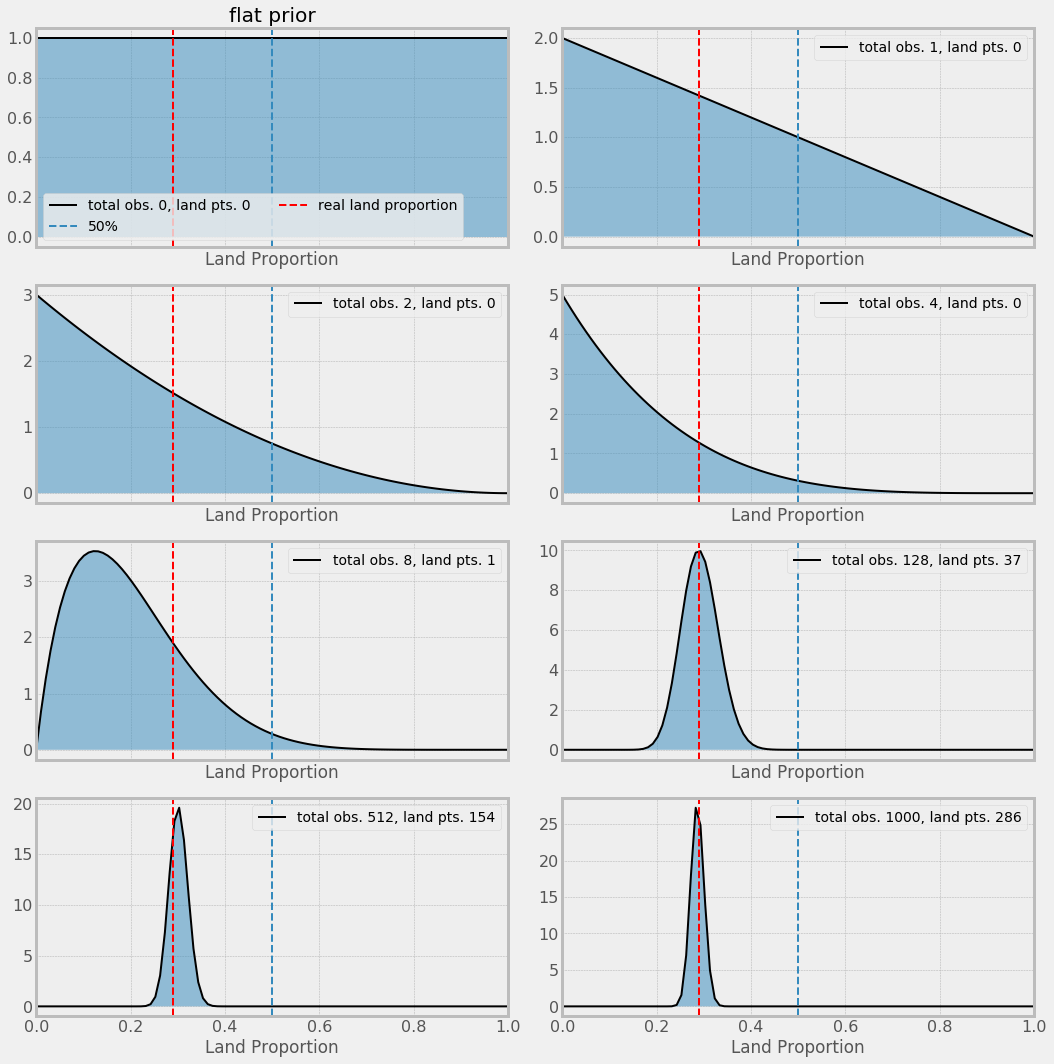

In [17]:
f, axs = pl.subplots(ncols=2, nrows=4, figsize=(15, 15), sharex=True)
#sb.set(font_scale=1.5)
for n, ax in zip(N, axs.ravel()):
    ocns = cdata[n]
    y = beta.pdf(theta_hyp, 1 + ocns, 1 + n - ocns)
    ax.plot(theta_hyp, y , color='k', label='total obs. %d, land pts. %d' %(n, ocns))
    ymax=5
    lbl1=None
    lbl2=None
    if n == 0:
        ymax=4
        lbl1 = '50%'
        lbl2 = 'real land proportion'
        ax.set_title('flat prior')
    ax.axvline(0.5, linestyle='--', label=lbl1)
    ax.axvline(theta_true, linestyle='--', color='r', label=lbl2)
    ax.legend(ncol=2)
    ax.fill_between(theta_hyp, y, alpha=0.5);
    ax.set_xlabel('Land Proportion')
    ax.set_xlim((0, 1))
f.tight_layout()

The above shows how the absence of any prior knowledge, encoded by a flat prior (top left plot,) results in wild swings in the first few iterations. This illustrates a common problem with uninformative priors, or for that matter outside of a bayesian context, the lack of a regularizing mechanism, when only scant data is available. The result then is often that the model gets "over-excited" by the particulars of a small dataset. This ceases to be a problem as the data collection continues and a more complete picture can surface. As this happens, high probability regions start to appear for specific values of the hypothesis. This mirrors the increase in certitude of where the actual proportion lies thereby serving, if need be, to illustrate the natural relationship between uncertainty and probability.

#### <u>Using a Weakly Regularizing Prior</u>

For the next scenario, I assume an awareness that land proportion is significantly lower than water proprortion, but only a vague understanding of what that difference is. For this I  use a weakly informative prior, where ignorance is reflected in the uncertainty around the initial guess. 

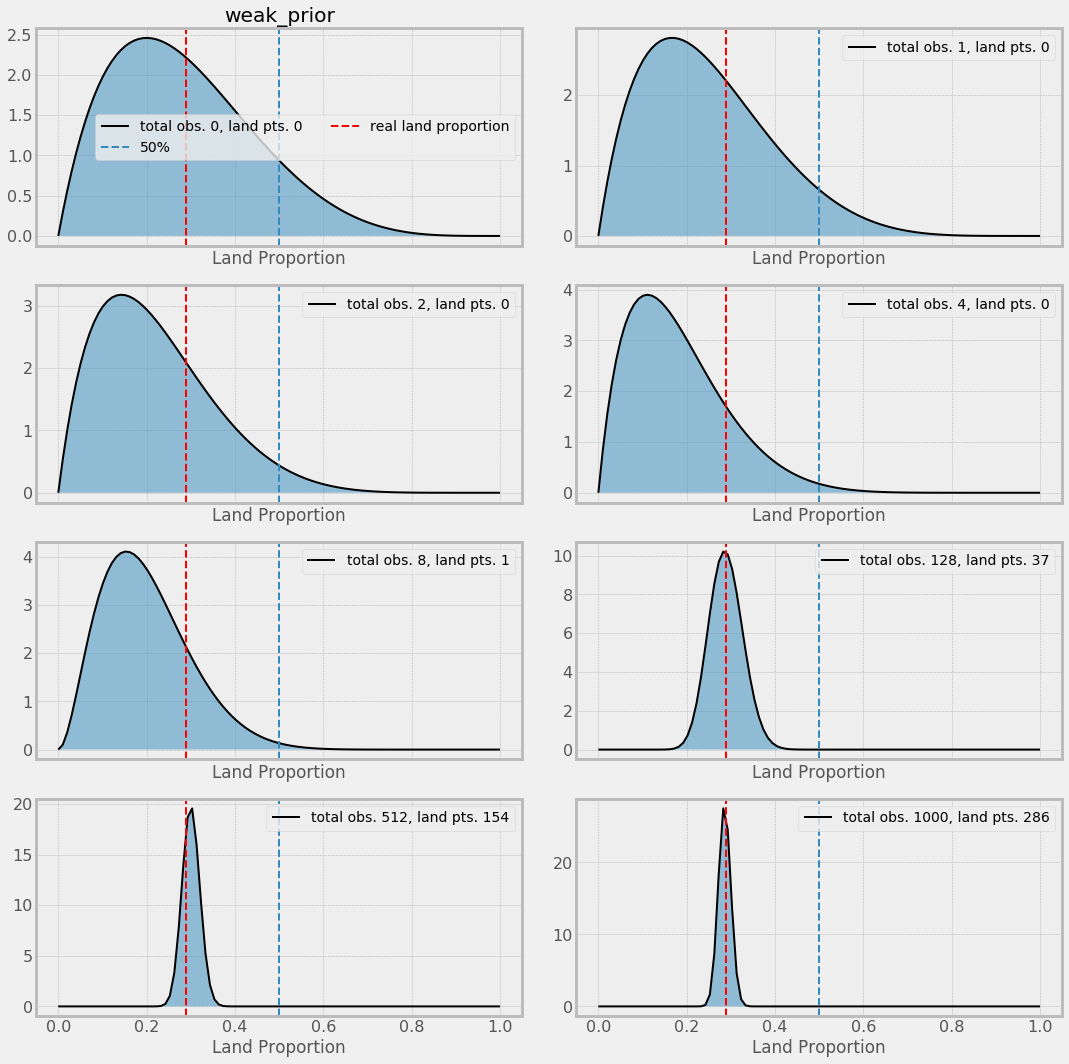

In [18]:
f, axs = pl.subplots(ncols=2, nrows=4, figsize=(15, 15), sharex=True)
#sb.set(font_scale=1.5)
for n ,ax in zip(N, axs.ravel()):
    ocns = cdata[n]
    y = beta.pdf(theta_hyp, 2 + ocns, 5 + n - ocns)
    ax.plot(theta_hyp, y, color='k',
           label='total obs. %d, land pts. %d' %(n, ocns))
    lbl1=None
    lbl2=None
    if n == 0:
        ymax=4
        lbl1 = '50%'
        lbl2 = 'real land proportion'
        ax.set_title('weak_prior')
    ax.axvline(0.5, linestyle='--', label=lbl1)
    ax.axvline(theta_true, linestyle='--', color='r', label=lbl2)
    ax.legend(ncol=2)
    ax.fill_between(theta_hyp,y,alpha=0.5);
    ax.set_xlabel('Land Proportion')
f.tight_layout()

The above illustrates the resilience of the model to allow too much weight to be given to the first few data points, when starting out with a weakly informative prior: even though no land is observed initially the posterior creeps  slower than the previous case toward the extreme case of a water world. Eventually both scenarios converge on the same answer, but the posterior in the second scenario has gone through less drastic upheavals in the process. 

On the other hand, a regularizing prior based on erroneous assumptions requires a larger amount of data than a flat prior to be overruled. One of the strengths of the Bayesian framework, however, is that the priors like the rest of the model, are explicit and laid bare for criticism, debate, and iterative model revision. 

In the [next post](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/Bayesian%20Modeling%20for%20Oceanographers%20-%202%20-%20Inference%20using%20OC4.ipynb), I will explore the use of MCMC sampling for Bayesian inference, and make use of the trove of information provided by posteriors for diagnosing models, suggest alternative model formulations, compare model performance, and predict model fitness on out-of-sample data.